# Simulating regression results under noisy SIR Model

This notebook evaluates the ability of our regression framework to obtain robust estimates for the impact of policy given the data available. Using a Monte Carlo approach, it simulates the outbreak progression using an SIR model, allowing for noise in the $\beta$ and $\gamma$ parameters, and allowing for $\beta$ to be affected by policy interventions. For each MC draw, it then uses our regression estimation framework to obtain estimates for the impact of those policies. We then compare the distribution of estimates with the true values, under various assumptions for the value of $\gamma$.

In [1]:
import numpy as np
import statsmodels.formula.api as smf
import pandas as pd
import xarray as xr
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
from codes import utils as cutil

sns.set(context="paper", style="white")

## Settings

In [2]:
# sim settings
n_days = 35
tsteps_per_day = 6
pop = 800000
I0 = 1 / pop
R0 = 0
n_samples = 1000
gamma_to_test = [0.05, 0.2, 0.35]

# policy settings
no_policy_growth_rate = 0.4
p1_effect = -0.05
p1_day_st, p1_day_end = 6, 11
p2_effect = -0.1
p2_day_st, p2_day_end = 6, 16
p3_effect = -0.2
p3_day_st, p3_day_end = 6, 21

# stochasticity settings
beta_noise_on = True
gamma_noise_on = True
beta_noise_sd = 0.08
gamma_noise_sd = 0.08

## Run simulations

In [3]:
## Run simulation
np.random.seed(0)

# initialize results array
estimates = np.empty((n_samples, 2, len(gamma_to_test), 4), dtype=np.float64)
estimates.fill(np.nan)

# get random policy start and end dates
p1_on_arr = np.random.randint(p1_day_st, p1_day_end, n_samples)
p2_on_arr = np.random.randint(p2_day_st, p2_day_end, n_samples)
p3_on_arr = np.random.randint(p3_day_st, p3_day_end, n_samples)

# time
ttotal = n_days * tsteps_per_day + 1
t = np.linspace(0, 1, ttotal) * n_days

# run sim
for gx, gamma in enumerate(gamma_to_test):
    print("Running sim for gamma =", gamma)
    for samp in range(n_samples):
        p1_on = p1_on_arr[samp]
        p2_on = p2_on_arr[samp]
        p3_on = p3_on_arr[samp]

        p1 = np.where(np.arange(ttotal) >= p1_on * tsteps_per_day, 1, 0)
        p2 = np.where(np.arange(ttotal) >= p2_on * tsteps_per_day, 1, 0)
        p3 = np.where(np.arange(ttotal) >= p3_on * tsteps_per_day, 1, 0)

        # drop sample if we have complete collinearity of policies
        # (in that case, would have "packaged" policies in regression)
        if len(set([p1.argmax(), p2.argmax(), p3.argmax()])) < 3:
            continue

        # time-series of no-uncertainty beta
        beta0 = np.ones(ttotal) * (no_policy_growth_rate + gamma)
        beta = beta0 + p1 * p1_effect + p2 * p2_effect + p3 * p3_effect

        # stochasticity
        if beta_noise_on:
            beta = np.random.normal(beta, beta_noise_sd)
            beta = np.where(beta > 0, beta, 0)
        if gamma_noise_on:
            gamma = np.random.normal(gamma, beta_noise_sd, ttotal)
            gamma = np.where(gamma > 0, gamma, 0)
        else:
            gamma = np.ones(ttotal) * gamma

        # adjust to single time-step rates
        this_beta = beta / tsteps_per_day
        this_gamma = gamma / tsteps_per_day

        # initial conditions
        S = np.ones(ttotal) * np.nan
        I = np.ones(ttotal) * np.nan
        R = np.ones(ttotal) * np.nan
        R[0] = R0
        I[0] = I0
        S[0] = 1 - I[0] - R[0]

        for i in range(1, ttotal):
            # this is the exponential rate b/c we can (it's an exponential ode)
            I[i] = np.exp(this_beta[i - 1] * S[i - 1] - this_gamma[i - 1]) * I[i - 1]

            # dR/dt is discretized
            R[i] = R[i - 1] + this_gamma[i - 1] * I[i - 1]

            # just take the diff to get S(t)
            S[i] = 1 - (I[i] + R[i])

        cum_cases = I + R

        # get in units of people
        S, I, R, cum_cases = S * pop, I * pop, R * pop, cum_cases * pop

        cases = pd.DataFrame(
            {
                "active_cases": I[::tsteps_per_day],
                "cum_cases": cum_cases[::tsteps_per_day],
                "p1": p1[::tsteps_per_day],
                "p2": p2[::tsteps_per_day],
                "p3": p3[::tsteps_per_day],
            },
            index=pd.Index(t.astype(int)[::tsteps_per_day], name="day"),
        )

        # get regression estimates
        for ix, i in enumerate(["active", "cum"]):
            case_var = i + "_cases"
            # only save if there is a single day without policies, so we have something
            # with which to estimate no-policy growth
            if cases.loc[cases[case_var] >= 10, ["p1", "p2", "p3"]].iloc[0].max() == 0:
                cases[i + "_logdiff"] = -np.log(cases[case_var]).diff(-1)
                res = smf.ols(
                    i + "_logdiff ~ p1 + p2 + p3", cases, subset=cases[case_var] >= 10,
                ).fit()
                estimates[samp, ix, gx] = res.params.values
                if res.params["Intercept"] < 0.2 and i == "cum":
                    stop

## Convert array to Dataset
coords = OrderedDict(
    sample=range(n_samples),
    case_type=["active", "cum"],
    gamma=gamma_to_test,
    parameter=["Intercept", "p1", "p2", "p3"],
)

attrs = dict(
    n_days=n_days,
    tsteps_per_day=tsteps_per_day,
    pop=pop,
    I0=I0,
    n_samples=n_samples,
    gamma_to_test=gamma_to_test,
    no_policy_growth_rate=no_policy_growth_rate,
    p1_effect=p1_effect,
    p1_day_st=p1_day_st,
    p1_day_end=p1_day_end,
    p2_effect=p2_effect,
    p2_day_st=p2_day_st,
    p2_day_end=p2_day_end,
    p3_effect=p3_effect,
    p3_day_st=p3_day_st,
    p3_day_end=p3_day_end,
    beta_noise_on=beta_noise_on,
    gamma_noise_on=gamma_noise_on,
    beta_noise_sd=beta_noise_sd,
    gamma_noise_sd=gamma_noise_sd,
)

estimates = xr.DataArray(
    estimates, coords=coords, dims=coords.keys(), attrs=attrs
).to_dataset(dim="parameter")

save_fpath = cutil.HOME / "results" / "other" / "mc_sim_estimates.nc"
save_fpath.parent.mkdir(exist_ok=True, parents=True)
estimates.to_netcdf(save_fpath)

Running sim for gamma = 0.05
Running sim for gamma = 0.2
Running sim for gamma = 0.35


## Plot results

### Histograms of estimates

These plots show potential bias in our estiamted parameters: The "no-policy" growth rate and the effects on that growth rate of each policy.

In [4]:
def plot_effect_histograms(estimates, case_type):
    fig, axs = plt.subplots(
        3, 4, figsize=(24, 12), tight_layout=True, sharey=True, sharex="col"
    )
    for gx, g in enumerate(estimates.gamma.values):
        this_est = estimates.sel(case_type=case_type, gamma=g)
        for jx, j in enumerate(["Intercept", "p1", "p2", "p3"]):
            this_est[j].plot.hist(ax=axs[gx, jx])
            axs[gx, jx].axvline(
                this_est[j].mean().item(), color="red", linestyle="--", label="True"
            )
        for jx, j in enumerate(
            ["no_policy_growth_rate", "p1_effect", "p2_effect", "p3_effect"]
        ):
            axs[gx, jx].axvline(
                estimates.attrs[j], color="k", linestyle="-", label="Mean Estimate"
            )
            axs[gx, jx].set_xlabel("")
            axs[gx, jx].set_title("")
        axs[gx, 0].set_ylabel(f"$\gamma$ = {g:.2f}")
    for jx, j in enumerate(["No-policy Growth", "p1", "p2", "p3"]):
        axs[0, jx].set_title(j)
    axs[0, 0].legend()
    return fig, axs

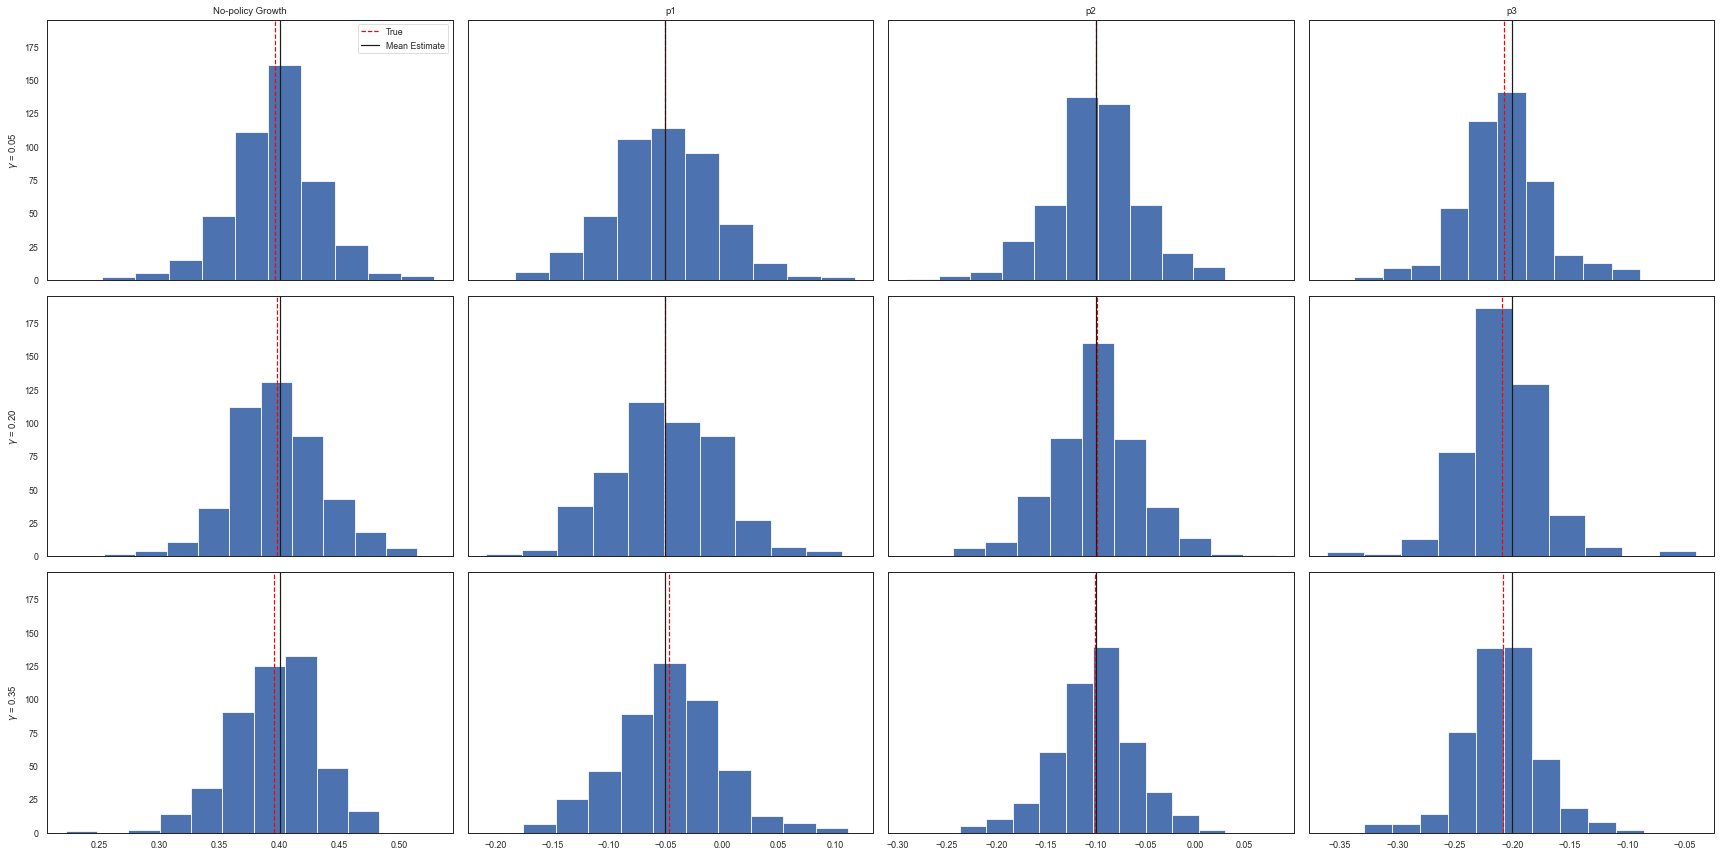

In [5]:
fig, axs = plot_effect_histograms(estimates, "active")

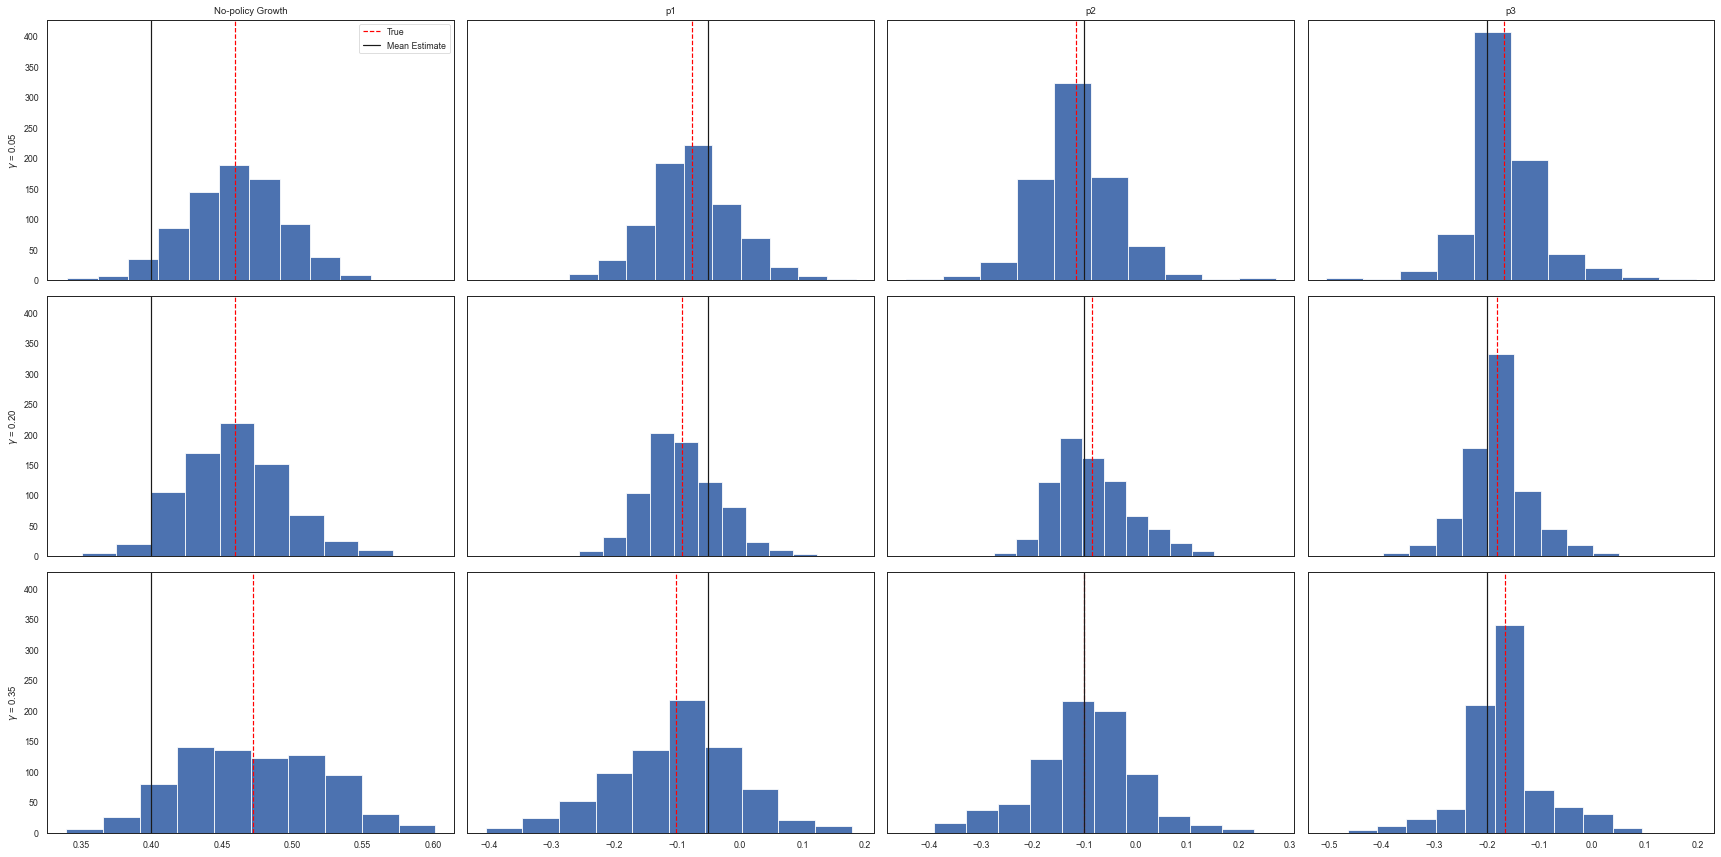

In [6]:
fig, axs = plot_effect_histograms(estimates, "cum")

### Convergence of cumulative cases growth to active cases growth

These plots show how the growth rates in cumulative cases converge to the growth rates in active cases under a S ~= 1 regime (assuming no policy and no noise in $\gamma$).

Text(0, 0.5, 'No-policy growth rate in cumulative cases')

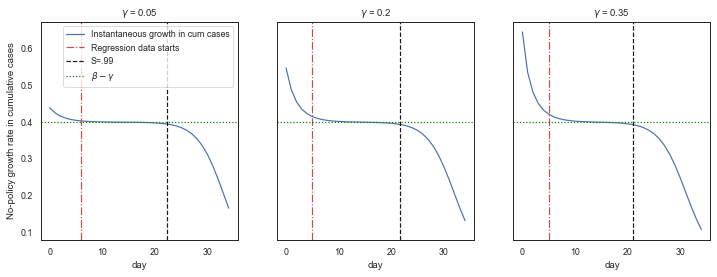

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for gx, gamma in enumerate(estimates.gamma.values):
    beta = np.ones(ttotal) * (no_policy_growth_rate + gamma)

    S = np.ones(ttotal) * np.nan
    I = np.ones(ttotal) * np.nan
    R = np.ones(ttotal) * np.nan

    this_beta = beta / tsteps_per_day
    this_gamma = gamma / tsteps_per_day

    t = np.linspace(0, 1, ttotal) * n_days

    R[0] = R0
    I[0] = I0
    S[0] = 1 - I[0]

    for i in range(1, ttotal):
        # this is the exponential rate b/c we can (it's an exponential ode)
        I[i] = np.exp(this_beta[i - 1] * S[i - 1] - this_gamma) * I[i - 1]

        # dR/dt is discretized
        R[i] = R[i - 1] + this_gamma * I[i - 1]

        # just take the diff to get S(t)
        S[i] = 1 - (I[i] + R[i])

    cum_cases = I + R
    S, I, R, cum_cases = S * pop, I * pop, R * pop, cum_cases * pop
    cases = pd.Series(
        cum_cases[::tsteps_per_day],
        index=pd.Index(t.astype(int)[::tsteps_per_day], name="day"),
    )
    cum_logdiff = -np.log(cases).diff(-1)
    cum_logdiff.plot(ax=axs[gx], label="Instantaneous growth in cum cases")

    # add line for S=.99
    start = cum_logdiff[cases >= 10].index[0]
    axs[gx].axvline(start, label="Regression data starts", color="r", linestyle="-.")
    lower_S = np.argmax((S / pop) < 0.99) / tsteps_per_day
    axs[gx].axvline(lower_S, label="S=.99", linestyle="--", color="k")
    axs[gx].set_title(f"$\gamma$ = {gamma}")
    axs[gx].axhline(estimates.no_policy_growth_rate, label=r"$\beta - \gamma$", color="green", linestyle=":")
axs[0].legend()
axs[0].set_ylabel("No-policy growth rate in cumulative cases")